## 4 Channel, AlexNet , Sun+Sky

In [1]:
# Math
import numpy as np
# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
from torch.optim.lr_scheduler import StepLR
# Custom
from loader import AlexNetModule_Shadow, Train_Shadow_Dataset, Eval_Shadow_Dataset
import os
from libs.projections import bin2Sphere
from utils import getAngle

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [3]:
BATCH_SIZE = 64
EPOCHS = 500

# 하이퍼파라미터 설정
learning_rate = 0.001

In [4]:
dataset = Train_Shadow_Dataset(csv_path='./mydata/trans_mode_label.csv')
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [5]:
eval_dataset = Eval_Shadow_Dataset(csv_path='./mydata/trans_mode_label.csv')
test_loader = eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [6]:
illuminationModule = AlexNetModule_Shadow().cuda()

In [7]:
from torchsummary import summary
summary(illuminationModule, input_size=(4,320,240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 79, 59]          31,040
               ELU-2           [-1, 64, 79, 59]               0
         MaxPool2d-3           [-1, 64, 39, 29]               0
            Conv2d-4          [-1, 192, 39, 29]         307,392
               ELU-5          [-1, 192, 39, 29]               0
         MaxPool2d-6          [-1, 192, 19, 14]               0
            Conv2d-7          [-1, 384, 19, 14]         663,936
               ELU-8          [-1, 384, 19, 14]               0
            Conv2d-9          [-1, 256, 19, 14]         884,992
              ELU-10          [-1, 256, 19, 14]               0
           Conv2d-11          [-1, 256, 19, 14]         590,080
              ELU-12          [-1, 256, 19, 14]               0
        MaxPool2d-13            [-1, 256, 9, 6]               0
          Dropout-14                [-1

In [8]:
sun_crit = nn.KLDivLoss()
prr_crit = nn.MSELoss()
# set optimizer
optimizer = optim.Adam(illuminationModule.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,)

In [9]:
def trainloop(module, lr=0.01, train_epochs=EPOCHS):
    global total_l, sky_l, sun_l
    # set training dataset
    dataset = Train_Shadow_Dataset(csv_path='./mydata/trans_mode_label.csv')
    train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

    # using KL divergence loss for sun distribution and MSE loss  
    sun_crit = nn.KLDivLoss()
    prr_crit = nn.MSELoss()
    # set optimizer
    optimizer = torch.optim.Adam(module.parameters(), lr=lr)

    # train the model
    cur_lr = lr

    for i in range(train_epochs):
        module.train()
        for i_batch, sample in enumerate(train_dataloader):
            # training input and targets
            img = sample['img'].cuda().float()
            label_dis, label_prrs = sample['dis'].cuda().float(), sample['prrs'].cuda().float()

            # forward pass 
            pred_dis, pred_prrs = module(img)
            beta = 0.1 # to compensate for the number od bins in output distribution
            sun_loss, prr_loss = sun_crit(pred_dis, label_dis), prr_crit(pred_prrs, label_prrs)
            loss = sun_loss + beta * prr_loss

            # optimization
            #if i_batch % 10 == 0 :
                #print('epoch:', i+1, 'steps:', i_batch+1, "sun_loss: ", 'loss:', loss.item())
            #    print('EPOCH : %d, STEPS : %d, sun_loss : %.5f, prr_loss : %.5f, loss : %.5f'%(i+1, i_batch+1, sun_loss.item(), prr_loss.item(), loss.item()))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_l.append(loss.item())
        sun_l.append(sun_loss.item())
        sky_l.append(prr_loss.item())
        
        print('='*20,'EPOCH : ', i,'='*20)
        print('-'*20,'TRAIN','-'*20)
        print("sun_loss : {:.5f},  prr_loss : {:.5f},  loss : {:.5f} ".format(sun_loss.item(), prr_loss.item(), loss.item()))
        print('-'*20,'TEST','-'*20)
        evaluate(module, eval_dataloader, optimizer, train_epochs)
        
        # Decay learning rate (0.5/15 epochs)
        if i % 15 == 0:
            cur_lr *= 0.5
            update_lr(optimizer, cur_lr)
        

    # Save the model checkpoint
    torch.save(module.state_dict(), 'shadow_17_9_alex_weights.pth')

In [10]:
test_total_l = []
test_sun_l = []
test_sky_l = []

def evaluate(module, eval_dataloader, optimizer, epoch):
    module.eval()
    
    sum_err = np.asarray([0, 0, 0, 0, 0, 0]).astype('float64')
    sum_loss = 0.0
    data_length = len(eval_dataloader)
    suns=[]
    suns_gt=[]
    bins=[]
    angular=[]
    
    for i, sample in enumerate(eval_dataloader):
        num_of_mini_batch = len(eval_dataloader)
        input_img = sample['img'].cuda().float()
        label_dis, label_prrs = sample['dis'].cuda().float(), sample['prrs'].cuda().float()
        sunpos = sample['sp'][0].numpy()

        with torch.no_grad():
            #print("="*20,i,"="*20)
            pred_dis, pred_prrs = module(input_img)
            #print("pred_dis  shape : ", pred_dis.shape) # (1, 256)
            #print("pred_dis : ", pred_dis)
            #print("pred_prrs : ", pred_prrs)
            #print(input_img)
            sun_loss, prr_loss = sun_crit(pred_dis, label_dis), prr_crit(pred_prrs, label_prrs)
            beta = 0.1
            loss = sun_loss + beta * prr_loss

            sum_loss += loss.item()
#                print("sum_loss : " , sum_loss)

            # calculate all prediction error
            bins.append(np.argmax(pred_dis.cpu().numpy()[0]))
            pred_sunpos = bin2Sphere(np.argmax(pred_dis.cpu().numpy()[0])) # predicted sun position is the bin with highest probability
            #print('pred_sunpos : ', pred_sunpos)
            suns.append(pred_sunpos)
            suns_gt.append(sunpos)
            sunpos_err = getAngle(sunpos, pred_sunpos)
#                print(sunpos)
#                print(pred_sunpos)
            angular.append(sunpos_err)
            # Sky sun kappa beta turbidity
            sky_err = abs(pred_prrs.cpu().numpy()[0][0] - label_prrs.cpu().numpy()[0][0]) + abs(pred_prrs.cpu().numpy()[0][1] - label_prrs.cpu().numpy()[0][1]) + abs(pred_prrs.cpu().numpy()[0][2] - label_prrs.cpu().numpy()[0][2])
            sun_color_err = abs(pred_prrs.cpu().numpy()[0][3] - label_prrs.cpu().numpy()[0][3]) + abs(pred_prrs.cpu().numpy()[0][4] - label_prrs.cpu().numpy()[0][4]) + abs(pred_prrs.cpu().numpy()[0][5] - label_prrs.cpu().numpy()[0][5])
            kappa_err = abs(pred_prrs.cpu().numpy()[0][6] - label_prrs.cpu().numpy()[0][6])
            beta_err = abs(pred_prrs.cpu().numpy()[0][7] - label_prrs.cpu().numpy()[0][7])
            tur_err = abs(pred_prrs.cpu().numpy()[0][8] - label_prrs.cpu().numpy()[0][8])
            sum_err += np.asarray([sunpos_err, sky_err, sun_color_err, kappa_err, beta_err, tur_err])

            #if i % 5 == 0:
            #            print("({:.0f}%)   sun_loss : {:.5f},  prr_loss : {:.5f},  loss : {:.5f} ".format(100.*i / num_of_mini_batch, sun_loss.item(), prr_loss.item(), loss.item()))
    # print average prediction errors across all testing dataset
#    print("data_length : ", data_length)
    print("sun_loss : {:.5f},  prr_loss : {:.5f},  loss : {:.5f} ".format(sun_loss.item(), prr_loss.item(), loss.item()))
    if epoch == 499:    
        print("="*20,"FINAL ERROR","="*20)
    #    print('Testing avg loss:', sum_loss/data_length)
        final_err = sum_err/data_length
    #    print('Average predictions error:')
        print('sun position (angular error):', final_err[0])
        print('sky color error :', final_err[1])
        print('sun color error:', final_err[2])
        print('kappa error :', final_err[3])
        print('beta error:', final_err[4])
        print('turbidity error:', final_err[5])

    test_total_l.append(loss.item())
    test_sun_l.append(sun_loss.item())
    test_sky_l.append(prr_loss.item())
    return suns_gt, suns, bins, angular

In [11]:
def main():

    # device configuration
    torch.cuda.set_device(0)
    # get network module 
    Module = AlexNetModule_Shadow().cuda()

    trainloop(Module)
    
total_l = []
sun_l = []
sky_l = []

if __name__ == '__main__':
    main()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


==================== EPOCH :  0 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01367,  prr_loss : 64.55968,  loss : 6.46964 
-------------------- TEST --------------------
sun_loss : 0.01833,  prr_loss : 57.71304,  loss : 5.78963 
==================== EPOCH :  1 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01331,  prr_loss : 66.28052,  loss : 6.64136 
-------------------- TEST --------------------
sun_loss : 0.01318,  prr_loss : 57.46838,  loss : 5.76002 
==================== EPOCH :  2 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01251,  prr_loss : 67.05338,  loss : 6.71785 
-------------------- TEST --------------------
sun_loss : 0.01268,  prr_loss : 57.30271,  loss : 5.74295 
==================== EPOCH :  3 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01286,  prr_loss : 67.00526,  loss : 6.71339 
-------------------- TEST ----------------

sun_loss : 0.01185,  prr_loss : 45.14064,  loss : 4.52592 
==================== EPOCH :  31 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01178,  prr_loss : 59.52407,  loss : 5.96419 
-------------------- TEST --------------------
sun_loss : 0.01171,  prr_loss : 47.10957,  loss : 4.72267 
==================== EPOCH :  32 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01146,  prr_loss : 53.43587,  loss : 5.35505 
-------------------- TEST --------------------
sun_loss : 0.01182,  prr_loss : 44.64370,  loss : 4.47619 
==================== EPOCH :  33 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01137,  prr_loss : 46.35570,  loss : 4.64694 
-------------------- TEST --------------------
sun_loss : 0.01178,  prr_loss : 46.08214,  loss : 4.62000 
==================== EPOCH :  34 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01107,  prr_loss : 40.459

sun_loss : 0.01184,  prr_loss : 44.64802,  loss : 4.47665 
==================== EPOCH :  62 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01123,  prr_loss : 50.90329,  loss : 5.10156 
-------------------- TEST --------------------
sun_loss : 0.01185,  prr_loss : 44.94178,  loss : 4.50603 
==================== EPOCH :  63 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01167,  prr_loss : 47.00482,  loss : 4.71215 
-------------------- TEST --------------------
sun_loss : 0.01194,  prr_loss : 44.52826,  loss : 4.46477 
==================== EPOCH :  64 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01145,  prr_loss : 45.02950,  loss : 4.51440 
-------------------- TEST --------------------
sun_loss : 0.01188,  prr_loss : 44.12741,  loss : 4.42462 
==================== EPOCH :  65 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01194,  prr_loss : 51.434

sun_loss : 0.01185,  prr_loss : 43.82764,  loss : 4.39461 
==================== EPOCH :  93 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01101,  prr_loss : 43.40110,  loss : 4.35112 
-------------------- TEST --------------------
sun_loss : 0.01187,  prr_loss : 43.56091,  loss : 4.36796 
==================== EPOCH :  94 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01105,  prr_loss : 41.21133,  loss : 4.13218 
-------------------- TEST --------------------
sun_loss : 0.01185,  prr_loss : 43.95210,  loss : 4.40706 
==================== EPOCH :  95 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01176,  prr_loss : 58.62833,  loss : 5.87459 
-------------------- TEST --------------------
sun_loss : 0.01184,  prr_loss : 43.71249,  loss : 4.38309 
==================== EPOCH :  96 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01111,  prr_loss : 53.240

sun_loss : 0.01187,  prr_loss : 44.07949,  loss : 4.41982 
==================== EPOCH :  124 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01142,  prr_loss : 47.59476,  loss : 4.77090 
-------------------- TEST --------------------
sun_loss : 0.01187,  prr_loss : 44.06803,  loss : 4.41867 
==================== EPOCH :  125 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01151,  prr_loss : 45.66851,  loss : 4.57837 
-------------------- TEST --------------------
sun_loss : 0.01187,  prr_loss : 44.01509,  loss : 4.41338 
==================== EPOCH :  126 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01098,  prr_loss : 41.38338,  loss : 4.14932 
-------------------- TEST --------------------
sun_loss : 0.01186,  prr_loss : 43.84208,  loss : 4.39607 
==================== EPOCH :  127 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01099,  prr_loss : 47

sun_loss : 0.01188,  prr_loss : 43.88655,  loss : 4.40054 
==================== EPOCH :  155 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01133,  prr_loss : 63.04772,  loss : 6.31610 
-------------------- TEST --------------------
sun_loss : 0.01188,  prr_loss : 44.15241,  loss : 4.42712 
==================== EPOCH :  156 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01164,  prr_loss : 51.10325,  loss : 5.12196 
-------------------- TEST --------------------
sun_loss : 0.01189,  prr_loss : 43.95036,  loss : 4.40692 
==================== EPOCH :  157 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01142,  prr_loss : 49.41373,  loss : 4.95279 
-------------------- TEST --------------------
sun_loss : 0.01189,  prr_loss : 43.92566,  loss : 4.40446 
==================== EPOCH :  158 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01177,  prr_loss : 46

sun_loss : 0.01188,  prr_loss : 43.86776,  loss : 4.39866 
==================== EPOCH :  186 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01106,  prr_loss : 44.49672,  loss : 4.46073 
-------------------- TEST --------------------
sun_loss : 0.01189,  prr_loss : 43.69593,  loss : 4.38148 
==================== EPOCH :  187 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01205,  prr_loss : 50.78585,  loss : 5.09063 
-------------------- TEST --------------------
sun_loss : 0.01188,  prr_loss : 43.81177,  loss : 4.39305 
==================== EPOCH :  188 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01097,  prr_loss : 46.48677,  loss : 4.65964 
-------------------- TEST --------------------
sun_loss : 0.01189,  prr_loss : 43.85709,  loss : 4.39760 
==================== EPOCH :  189 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01174,  prr_loss : 54

sun_loss : 0.01188,  prr_loss : 43.93093,  loss : 4.40497 
==================== EPOCH :  217 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01110,  prr_loss : 46.05344,  loss : 4.61644 
-------------------- TEST --------------------
sun_loss : 0.01188,  prr_loss : 43.92764,  loss : 4.40464 
==================== EPOCH :  218 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01144,  prr_loss : 45.19097,  loss : 4.53054 
-------------------- TEST --------------------
sun_loss : 0.01188,  prr_loss : 43.91060,  loss : 4.40295 
==================== EPOCH :  219 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01135,  prr_loss : 43.54781,  loss : 4.36613 
-------------------- TEST --------------------
sun_loss : 0.01188,  prr_loss : 43.81078,  loss : 4.39296 
==================== EPOCH :  220 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01122,  prr_loss : 46

sun_loss : 0.01189,  prr_loss : 43.89901,  loss : 4.40179 
==================== EPOCH :  248 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01117,  prr_loss : 51.11534,  loss : 5.12270 
-------------------- TEST --------------------
sun_loss : 0.01188,  prr_loss : 43.91959,  loss : 4.40384 
==================== EPOCH :  249 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01102,  prr_loss : 46.60747,  loss : 4.67177 
-------------------- TEST --------------------
sun_loss : 0.01190,  prr_loss : 43.89643,  loss : 4.40154 
==================== EPOCH :  250 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01090,  prr_loss : 43.90000,  loss : 4.40090 
-------------------- TEST --------------------
sun_loss : 0.01189,  prr_loss : 43.71321,  loss : 4.38321 
==================== EPOCH :  251 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01144,  prr_loss : 42

sun_loss : 0.01190,  prr_loss : 43.73386,  loss : 4.38528 
==================== EPOCH :  279 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01142,  prr_loss : 48.54449,  loss : 4.86587 
-------------------- TEST --------------------
sun_loss : 0.01188,  prr_loss : 43.84296,  loss : 4.39617 
==================== EPOCH :  280 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01116,  prr_loss : 41.63649,  loss : 4.17481 
-------------------- TEST --------------------
sun_loss : 0.01187,  prr_loss : 43.65248,  loss : 4.37712 
==================== EPOCH :  281 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01117,  prr_loss : 48.74868,  loss : 4.88604 
-------------------- TEST --------------------
sun_loss : 0.01190,  prr_loss : 43.64331,  loss : 4.37623 
==================== EPOCH :  282 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01101,  prr_loss : 46

sun_loss : 0.01187,  prr_loss : 43.82047,  loss : 4.39392 
==================== EPOCH :  310 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01132,  prr_loss : 47.96691,  loss : 4.80801 
-------------------- TEST --------------------
sun_loss : 0.01189,  prr_loss : 43.75908,  loss : 4.38780 
==================== EPOCH :  311 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01127,  prr_loss : 53.58548,  loss : 5.36982 
-------------------- TEST --------------------
sun_loss : 0.01188,  prr_loss : 43.93366,  loss : 4.40524 
==================== EPOCH :  312 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01099,  prr_loss : 44.19648,  loss : 4.43064 
-------------------- TEST --------------------
sun_loss : 0.01189,  prr_loss : 43.79406,  loss : 4.39130 
==================== EPOCH :  313 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01184,  prr_loss : 53

sun_loss : 0.01188,  prr_loss : 43.84016,  loss : 4.39590 
==================== EPOCH :  341 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01136,  prr_loss : 43.23528,  loss : 4.33489 
-------------------- TEST --------------------
sun_loss : 0.01190,  prr_loss : 43.66291,  loss : 4.37819 
==================== EPOCH :  342 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01131,  prr_loss : 37.32260,  loss : 3.74357 
-------------------- TEST --------------------
sun_loss : 0.01191,  prr_loss : 43.62434,  loss : 4.37434 
==================== EPOCH :  343 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01126,  prr_loss : 49.02454,  loss : 4.91371 
-------------------- TEST --------------------
sun_loss : 0.01187,  prr_loss : 43.77700,  loss : 4.38957 
==================== EPOCH :  344 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01108,  prr_loss : 41

sun_loss : 0.01188,  prr_loss : 43.87594,  loss : 4.39948 
==================== EPOCH :  372 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01129,  prr_loss : 43.76559,  loss : 4.38785 
-------------------- TEST --------------------
sun_loss : 0.01189,  prr_loss : 43.82011,  loss : 4.39390 
==================== EPOCH :  373 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01127,  prr_loss : 45.41087,  loss : 4.55235 
-------------------- TEST --------------------
sun_loss : 0.01188,  prr_loss : 43.77170,  loss : 4.38905 
==================== EPOCH :  374 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01135,  prr_loss : 52.73579,  loss : 5.28493 
-------------------- TEST --------------------
sun_loss : 0.01187,  prr_loss : 43.89339,  loss : 4.40121 
==================== EPOCH :  375 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01151,  prr_loss : 44

sun_loss : 0.01187,  prr_loss : 43.66957,  loss : 4.37883 
==================== EPOCH :  403 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01158,  prr_loss : 45.46931,  loss : 4.55851 
-------------------- TEST --------------------
sun_loss : 0.01188,  prr_loss : 43.90264,  loss : 4.40214 
==================== EPOCH :  404 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01156,  prr_loss : 48.10344,  loss : 4.82191 
-------------------- TEST --------------------
sun_loss : 0.01188,  prr_loss : 43.83175,  loss : 4.39506 
==================== EPOCH :  405 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01092,  prr_loss : 41.55825,  loss : 4.16675 
-------------------- TEST --------------------
sun_loss : 0.01188,  prr_loss : 43.81240,  loss : 4.39312 
==================== EPOCH :  406 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01133,  prr_loss : 40

sun_loss : 0.01188,  prr_loss : 43.79710,  loss : 4.39159 
==================== EPOCH :  434 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01118,  prr_loss : 49.92920,  loss : 5.00410 
-------------------- TEST --------------------
sun_loss : 0.01190,  prr_loss : 43.88986,  loss : 4.40088 
==================== EPOCH :  435 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01082,  prr_loss : 46.63839,  loss : 4.67466 
-------------------- TEST --------------------
sun_loss : 0.01189,  prr_loss : 43.93078,  loss : 4.40496 
==================== EPOCH :  436 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01125,  prr_loss : 43.59962,  loss : 4.37122 
-------------------- TEST --------------------
sun_loss : 0.01189,  prr_loss : 43.98537,  loss : 4.41043 
==================== EPOCH :  437 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01185,  prr_loss : 54

sun_loss : 0.01190,  prr_loss : 43.78827,  loss : 4.39073 
==================== EPOCH :  465 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01116,  prr_loss : 46.30962,  loss : 4.64213 
-------------------- TEST --------------------
sun_loss : 0.01189,  prr_loss : 43.81326,  loss : 4.39321 
==================== EPOCH :  466 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01070,  prr_loss : 41.56541,  loss : 4.16724 
-------------------- TEST --------------------
sun_loss : 0.01188,  prr_loss : 43.84534,  loss : 4.39641 
==================== EPOCH :  467 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01096,  prr_loss : 46.08614,  loss : 4.61957 
-------------------- TEST --------------------
sun_loss : 0.01188,  prr_loss : 43.91349,  loss : 4.40323 
==================== EPOCH :  468 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01103,  prr_loss : 42

sun_loss : 0.01189,  prr_loss : 43.77502,  loss : 4.38939 
==================== EPOCH :  496 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01184,  prr_loss : 51.39254,  loss : 5.15109 
-------------------- TEST --------------------
sun_loss : 0.01189,  prr_loss : 43.99234,  loss : 4.41112 
==================== EPOCH :  497 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01134,  prr_loss : 43.99446,  loss : 4.41079 
-------------------- TEST --------------------
sun_loss : 0.01189,  prr_loss : 43.77819,  loss : 4.38971 
==================== EPOCH :  498 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01108,  prr_loss : 51.31512,  loss : 5.14259 
-------------------- TEST --------------------
sun_loss : 0.01187,  prr_loss : 43.69395,  loss : 4.38127 
==================== EPOCH :  499 ====================
-------------------- TRAIN --------------------
sun_loss : 0.01124,  prr_loss : 44

In [12]:
# train loss
print(total_l)

[6.46964168548584, 6.641362190246582, 6.717849254608154, 6.7133893966674805, 5.9785661697387695, 6.144741058349609, 5.4662017822265625, 5.981968879699707, 4.955731391906738, 5.315220832824707, 5.613943099975586, 6.498174667358398, 6.073569297790527, 5.482048988342285, 5.62267541885376, 5.335994720458984, 5.660087585449219, 5.840673446655273, 6.54932165145874, 5.959272861480713, 4.962446689605713, 4.9510087966918945, 5.097261428833008, 5.574530601501465, 4.713964462280273, 5.85258150100708, 4.756500244140625, 4.626968860626221, 6.557313919067383, 5.284853935241699, 4.493856430053711, 5.964186191558838, 5.355045318603516, 4.64693546295166, 4.057004928588867, 4.744776248931885, 4.457300662994385, 4.717020511627197, 6.27865743637085, 5.360816955566406, 4.627310752868652, 4.392073154449463, 5.150351524353027, 4.698822975158691, 5.1298828125, 5.2471442222595215, 4.900345802307129, 4.946255207061768, 5.97878360748291, 4.959409236907959, 4.9676127433776855, 4.5834550857543945, 4.48964881896972

In [13]:
print(sky_l)

[64.55968475341797, 66.280517578125, 67.05338287353516, 67.00525665283203, 59.66157913208008, 61.31951141357422, 54.53335952758789, 59.69097137451172, 49.43411636352539, 53.03132247924805, 56.0231819152832, 64.86491394042969, 60.615692138671875, 54.703773498535156, 56.1104736328125, 53.24428939819336, 56.481258392333984, 58.29106903076172, 65.37344360351562, 59.480220794677734, 49.50971603393555, 49.39637756347656, 50.85252380371094, 55.6299934387207, 47.02046203613281, 58.40810775756836, 47.45221710205078, 46.15810012817383, 65.45182037353516, 52.733089447021484, 44.825538635253906, 59.524070739746094, 53.435874938964844, 46.3557014465332, 40.45939254760742, 47.332664489746094, 44.45860290527344, 47.05767822265625, 62.667362213134766, 53.49300003051758, 46.15757751464844, 43.80244445800781, 51.39173126220703, 46.87665557861328, 51.18915939331055, 52.35072326660156, 48.888633728027344, 49.3460578918457, 59.66936492919922, 49.47710037231445, 49.56103515625, 45.720123291015625, 44.783447

In [14]:
print(sun_l)

[0.01367343869060278, 0.013310485519468784, 0.012510852888226509, 0.012863397598266602, 0.012408171780407429, 0.012789695523679256, 0.012865559197962284, 0.012871933169662952, 0.012319651432335377, 0.012088079005479813, 0.011624998413026333, 0.011683003045618534, 0.011999905109405518, 0.011671654880046844, 0.011628134176135063, 0.01156544778496027, 0.011961289681494236, 0.011566458269953728, 0.011977234855294228, 0.011250535026192665, 0.011475102975964546, 0.011370990425348282, 0.01200922578573227, 0.011531570926308632, 0.01191790122538805, 0.011770516633987427, 0.011278723366558552, 0.011159129440784454, 0.012131783179938793, 0.011544589884579182, 0.011302410624921322, 0.011778782121837139, 0.011457867920398712, 0.011365212500095367, 0.011065629310905933, 0.011510038748383522, 0.011440122500061989, 0.01125255599617958, 0.011920727789402008, 0.011517214588820934, 0.011552980169653893, 0.011828340590000153, 0.011178310960531235, 0.011157308705151081, 0.010966666042804718, 0.012071459554

In [15]:
print(test_total_l)

[5.789632797241211, 5.760016918182373, 5.742953777313232, 5.549252510070801, 5.518589973449707, 5.417305946350098, 5.517522811889648, 5.311132907867432, 5.266739368438721, 5.419811725616455, 5.2568464279174805, 5.158182621002197, 5.04671049118042, 5.006164073944092, 4.969353675842285, 4.887943267822266, 4.9312005043029785, 4.879115104675293, 4.874110698699951, 4.85774564743042, 4.7239861488342285, 4.774359226226807, 5.089024543762207, 4.7705183029174805, 4.801242828369141, 4.673844814300537, 4.710390090942383, 4.759463787078857, 4.612223148345947, 4.621639251708984, 4.525915145874023, 4.7226715087890625, 4.476194858551025, 4.619997978210449, 4.680485248565674, 4.662968158721924, 4.456273078918457, 4.542968273162842, 4.633180618286133, 4.880030632019043, 4.462353229522705, 4.596105098724365, 4.514495849609375, 4.5343732833862305, 4.442424297332764, 4.540016174316406, 4.464548110961914, 4.391969203948975, 4.4465861320495605, 4.38310432434082, 4.420636177062988, 4.3761372566223145, 4.5715

In [16]:
print(test_sky_l)

[57.71303939819336, 57.46837615966797, 57.302711486816406, 55.367488861083984, 55.06086730957031, 54.048545837402344, 55.05194854736328, 52.98894119262695, 52.54597091674805, 54.07438659667969, 52.44740676879883, 51.46210479736328, 50.347755432128906, 49.94057846069336, 49.575557708740234, 48.76137161254883, 49.193546295166016, 48.673301696777344, 48.62199020385742, 48.459877014160156, 47.12078094482422, 47.626121520996094, 50.770606994628906, 47.58596420288086, 47.89387893676758, 46.620784759521484, 46.985469818115234, 47.47529983520508, 46.00634765625, 46.09749984741211, 45.1406364440918, 47.10956573486328, 44.64370346069336, 46.0821418762207, 46.68639373779297, 46.51064682006836, 44.44574737548828, 45.31121826171875, 46.214115142822266, 48.68312072753906, 44.504669189453125, 45.84328079223633, 45.02634048461914, 45.22480392456055, 44.30451202392578, 45.28260040283203, 44.52652359008789, 43.800453186035156, 44.346744537353516, 43.71062088012695, 44.087852478027344, 43.643150329589844

In [17]:
print(test_sun_l)

[0.01832890510559082, 0.01317922305315733, 0.012682285159826279, 0.012503758072853088, 0.01250310055911541, 0.01245107688009739, 0.01232790108770132, 0.01223862823098898, 0.012142233550548553, 0.012372871860861778, 0.012105378322303295, 0.011971977539360523, 0.011934822425246239, 0.01210611592978239, 0.011798135004937649, 0.011805825866758823, 0.011845444329082966, 0.011784831993281841, 0.011911283247172832, 0.011757955886423588, 0.01190796960145235, 0.011746692471206188, 0.011963969096541405, 0.011921882629394531, 0.011854429729282856, 0.011766294948756695, 0.011843240819871426, 0.011933720670640469, 0.011587994173169136, 0.01188912708312273, 0.011851074174046516, 0.011714902706444263, 0.011824382469058037, 0.011783461086452007, 0.011845813132822514, 0.01190323568880558, 0.011698168702423573, 0.011846504174172878, 0.011768633499741554, 0.011718349531292915, 0.011885911226272583, 0.011776749975979328, 0.011861913837492466, 0.011892557144165039, 0.011973105370998383, 0.01175600569695234

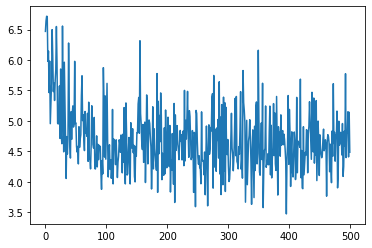

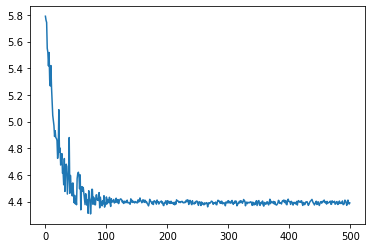

In [19]:
import matplotlib.pyplot as plt
plt.plot(total_l)
plt.show()

plt.plot(test_total_l)
plt.show()

In [4]:
import argparse
import progressbar
def evaluate(module):
    # loss function
    sun_crit = nn.KLDivLoss()
    prr_crit = nn.MSELoss()

    # data loader
    eval_dataset = Eval_Shadow_Dataset(csv_path='./mydata/trans_mode_label.csv')
    eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=False, num_workers=4)
    print(eval_dataloader)

    module.eval()
    
    sum_err = np.asarray([0, 0, 0, 0, 0, 0]).astype('float64')
    sum_loss = 0.0
    data_length = len(eval_dataloader)
    suns=[]
    suns_gt=[]
    bins=[]
    angular=[]
    with progressbar.ProgressBar(max_value=data_length) as bar:
        for i, sample in enumerate(eval_dataloader):
            input_img = sample['img'].cuda().float()
            label_dis, label_prrs = sample['dis'].cuda().float(), sample['prrs'].cuda().float()
            sunpos = sample['sp'][0].numpy()

            with torch.no_grad():
                #print("="*20,i,"="*20)
                pred_dis, pred_prrs = module(input_img)
                #print("pred_dis  shape : ", pred_dis.shape) # (1, 256)
                #print("pred_dis : ", pred_dis)
                #print("pred_prrs : ", pred_prrs)
                #print(input_img)
                sun_loss, prr_loss = sun_crit(pred_dis, label_dis), prr_crit(pred_prrs, label_prrs)
                beta = 0.1
                loss = sun_loss + beta * prr_loss
                sum_loss += loss.item()
                
                # calculate all prediction error
                bins.append(np.argmax(pred_dis.cpu().numpy()[0]))
                pred_sunpos = bin2Sphere(np.argmax(pred_dis.cpu().numpy()[0])) # predicted sun position is the bin with highest probability
                #print('pred_sunpos : ', pred_sunpos)
                suns.append(pred_sunpos)
                suns_gt.append(sunpos)
                sunpos_err = getAngle(sunpos, pred_sunpos)
#                print(sunpos)
#                print(pred_sunpos)
                angular.append(sunpos_err)
                # Sky sun kappa beta turbidity
                sky_err = abs(pred_prrs.cpu().numpy()[0][0] - label_prrs.cpu().numpy()[0][0]) + abs(pred_prrs.cpu().numpy()[0][1] - label_prrs.cpu().numpy()[0][1]) + abs(pred_prrs.cpu().numpy()[0][2] - label_prrs.cpu().numpy()[0][2])
                sun_color_err = abs(pred_prrs.cpu().numpy()[0][3] - label_prrs.cpu().numpy()[0][3]) + abs(pred_prrs.cpu().numpy()[0][4] - label_prrs.cpu().numpy()[0][4]) + abs(pred_prrs.cpu().numpy()[0][5] - label_prrs.cpu().numpy()[0][5])
                kappa_err = abs(pred_prrs.cpu().numpy()[0][6] - label_prrs.cpu().numpy()[0][6])
                beta_err = abs(pred_prrs.cpu().numpy()[0][7] - label_prrs.cpu().numpy()[0][7])
                tur_err = abs(pred_prrs.cpu().numpy()[0][8] - label_prrs.cpu().numpy()[0][8])
                sum_err += np.asarray([sunpos_err, sky_err, sun_color_err, kappa_err, beta_err, tur_err])
            bar.update(i)
    # print average prediction errors across all testing dataset
    print("="*20,"FINAL ERROR","="*20)
    print('Testing avg loss:', sum_loss/data_length)
    final_err = sum_err/data_length
    print('Average predictions error:')
    print('sun position (angular error):', final_err[0])
    print('sky color error :', final_err[1])
    print('sun color error:', final_err[2])
    print('kappa error :', final_err[3])
    print('beta error:', final_err[4])
    print('turbidity error:', final_err[5])
    return suns_gt, suns, bins, angular

In [5]:
def main(args):
    print('loading weights ...')
    # device configuration
    torch.cuda.set_device(0)
    # get network module 
    module = AlexNetModule_Shadow().cuda()
    #load pre-trained weight
    module.load_state_dict(torch.load(args.pre_trained))

    print('start evaluating ...')
    suns_gt, suns, bins, angular= evaluate(module)
    print('evaluation done!')
    return suns_gt, suns, bins, angular

In [6]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
  
    parser.add_argument('--pre_trained', default='./shadow_17_9_alex_weights.pth', help='pre-trained weight path')
    
    args = parser.parse_args(args=[])
    
    suns_gt, suns, bins, angular = main(args)

loading weights ...
start evaluating ...


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
100% (446 of 446) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


==================== FINAL ERROR ====================
Testing avg loss: 4.684539959035112
Average predictions error:
sun position (angular error): 63.64233722757053
sky color error : 0.22339605008807417
sun color error: 1.2631760650260098
kappa error : 0.06726240068507035
beta error: 9.66823349097919
turbidity error: 16.296344312317167
evaluation done!


In [7]:
print(angular)

[28.9021530761668, 77.78828610659875, 120.7300235095926, 120.7300235095926, 92.2854915754442, 92.2854915754442, 14.827237538351255, 105.3626864569204, 108.49845356686373, 39.148271344446016, 49.04819033611861, 14.324123304442999, 0.6397194580565669, 14.324123304442999, 38.850589084999285, 120.5954046897809, 133.85403070290545, 133.85403070290545, 75.41089509624786, 75.41089509624786, 61.31606292153489, 84.3873563561804, 79.10455073592351, 14.049394303836737, 122.68075538060141, 96.7991072750542, 96.7991072750542, 96.7991072750542, 96.7991072750542, 96.7991072750542, 100.6818042153449, 108.82771272894554, 108.82771272894554, 122.13648114526536, 40.849312657149625, 40.849312657149625, 41.995415653483, 12.837706833178519, 41.26660846211079, 44.37203949343394, 98.09923708313627, 44.37203949343394, 27.080251782235724, 52.36143392531788, 35.56735142101579, 35.56735142101579, 35.56735142101579, 74.75344531276812, 5.0153327655385445, 26.533845404379182, 92.2360080900699, 43.356178656366865, 75